In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


##Load Datasets

Replace the file paths with your Google Drive paths or local paths.

In [ ]:
# Trader data
# For newer Pandas versions (>=1.3)
trades = pd.read_csv('/content/drive/MyDrive/ds_bhimashankar/csv_files/historical_data.csv', on_bad_lines='skip')


# Fear & Greed data
sentiment = pd.read_csv('/content/drive/MyDrive/ds_bhimashankar/csv_files/fear_greed_index.csv')


/tmp/ipython-input-2570730149.py:3: DtypeWarning: Columns (2,3,4,7,9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv('/content/drive/MyDrive/ds_bhimashankar/csv_files/historical_data.csv', on_bad_lines='skip')


##Inspect Column Names

In [ ]:
print("Trader Columns:", trades.columns)
print("Sentiment Columns:", sentiment.columns)


Trader Columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Sentiment Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


##Convert Timestamps to Dates

From your datasets:

Trades: column 'timestamp' → Unix timestamp

Sentiment: column 'Timestamp IST' → string

In [ ]:
# Trades: convert Unix timestamp to date
trades['date'] = pd.to_datetime(trades['Timestamp'], unit='ms').dt.date

# Sentiment: convert 'Timestamp IST' to date
sentiment['date'] = pd.to_datetime(sentiment['timestamp'], unit='s').dt.date

##Merge Datasets

In [105]:
merged_data = pd.merge(trades, sentiment[['date','classification', 'value']], on='date', how='left')

# Check merged data
print(merged_data[['date','classification','value','Closed PnL']].head())

         date classification  value Closed PnL
0  2024-10-27          Greed   74.0          0
1  2024-10-27          Greed   74.0          0
2  2024-10-27          Greed   74.0          0
3  2024-10-27          Greed   74.0          0
4  2024-10-27          Greed   74.0          0


##Clean Data

In [109]:
# Drop rows where classification is missing
merged_data_cleaned = merged_data.dropna(subset=['classification']).copy()

# Ensure Closed PnL, Size USD, and Start Position are numeric
merged_data_cleaned['Closed PnL'] = pd.to_numeric(merged_data_cleaned['Closed PnL'], errors='coerce')
merged_data_cleaned['Size USD'] = pd.to_numeric(merged_data_cleaned['Size USD'], errors='coerce')
merged_data_cleaned['Start Position'] = pd.to_numeric(merged_data_cleaned['Start Position'], errors='coerce')


# Quick check
print(merged_data_cleaned.dtypes)
print(merged_data_cleaned.groupby('classification')['Closed PnL'].count())

Account              object
Coin                 object
Execution Price      object
Size Tokens          object
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID             object
Crossed              object
Fee                 float64
Trade ID            float64
Timestamp           float64
date                 object
classification       object
value               float64
dtype: object
classification
Extreme Greed      6961
Fear             136199
Greed             47423
Neutral           10944
Name: Closed PnL, dtype: int64


##Next Steps for Assignment Analysis

1. Plot Profitability by Sentiment

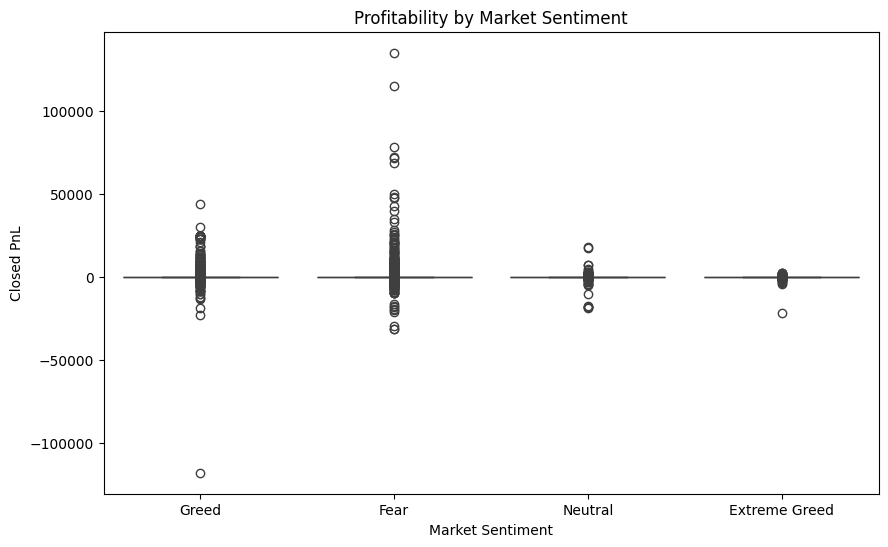

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='Closed PnL', data=merged_data_cleaned)
plt.title('Profitability by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.show()


2. Trade Volume Analysis

Analyze total trade volume (Size USD or Size Tokens) under different market sentiments.

  classification      Size USD
0  Extreme Greed  3.939895e+07
1           Fear  6.324175e+08
2          Greed  1.156259e+08
3        Neutral  2.474870e+07


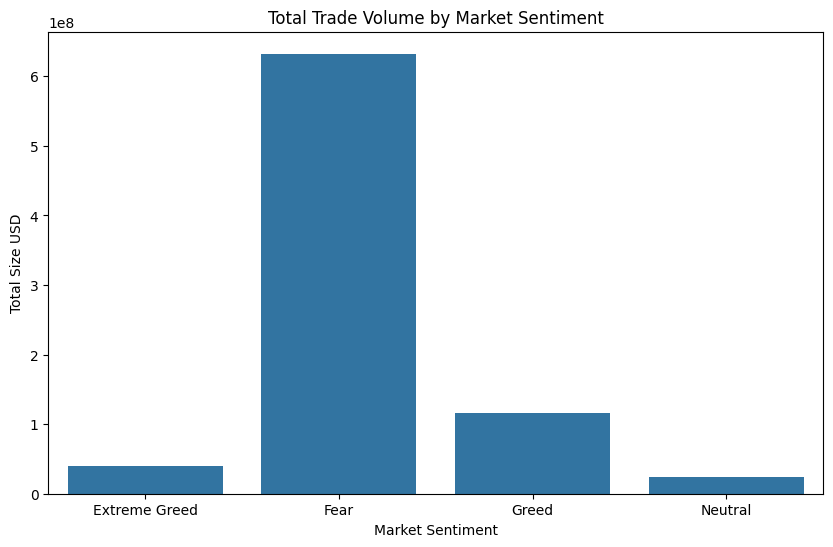

In [108]:
# Total volume by sentiment
volume_by_sentiment = merged_data_cleaned.groupby('classification')['Size USD'].sum().reset_index()
print(volume_by_sentiment)

# Visualization
plt.figure(figsize=(10,6))
sns.barplot(x='classification', y='Size USD', data=volume_by_sentiment)
plt.title('Total Trade Volume by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Size USD')
plt.show()


3. Leverage / Risk Analysis

Examine average leverage and usage of margin (Crossed) under Fear vs Greed.

  classification  Start Position
0  Extreme Greed    70317.381387
1           Fear     3496.804072
2          Greed    15831.453849
3        Neutral    -8861.954800
Crossed classification  False   True  FALSE   TRUE
0        Extreme Greed   3113   3733     18     97
1                 Fear  26194  40454  36360  33191
2                Greed   8627  25476   7669   5651
3              Neutral   1577   6636    808   1923


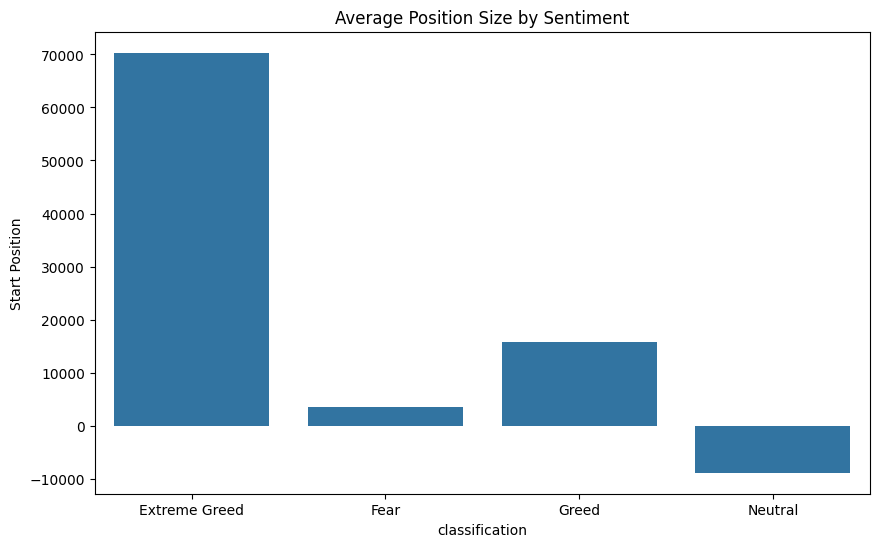

<Figure size 1000x600 with 0 Axes>

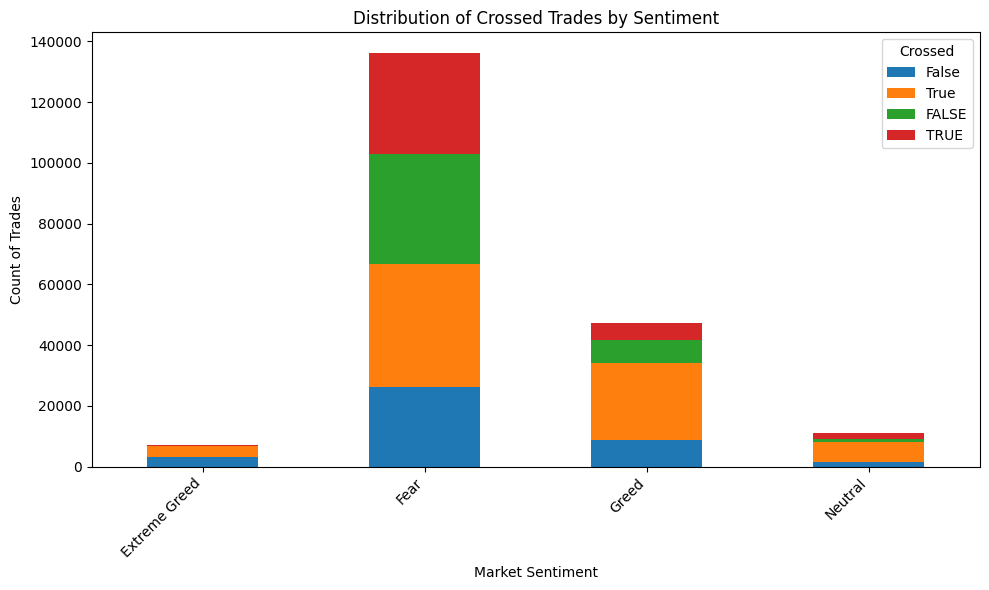

In [111]:
# Average leverage by sentiment
leverage_by_sentiment = merged_data_cleaned.groupby('classification')['Start Position'].mean().reset_index()
print(leverage_by_sentiment)

# Crossed (margin) usage: Count of 'Crossed' trades
crossed_by_sentiment = merged_data_cleaned.groupby('classification')['Crossed'].value_counts().unstack(fill_value=0).reset_index()
print(crossed_by_sentiment)

# Visualization: Leverage
plt.figure(figsize=(10,6))
sns.barplot(x='classification', y='Start Position', data=leverage_by_sentiment)
plt.title('Average Position Size by Sentiment')
plt.show()

# Visualization: Crossed (margin) usage
plt.figure(figsize=(10,6))
crossed_by_sentiment.plot(x='classification', kind='bar', stacked=True, figsize=(10,6))
plt.title('Distribution of Crossed Trades by Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Count of Trades')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

4. Trade Direction Analysis

Check the distribution of Buy vs Sell trades under each sentiment.

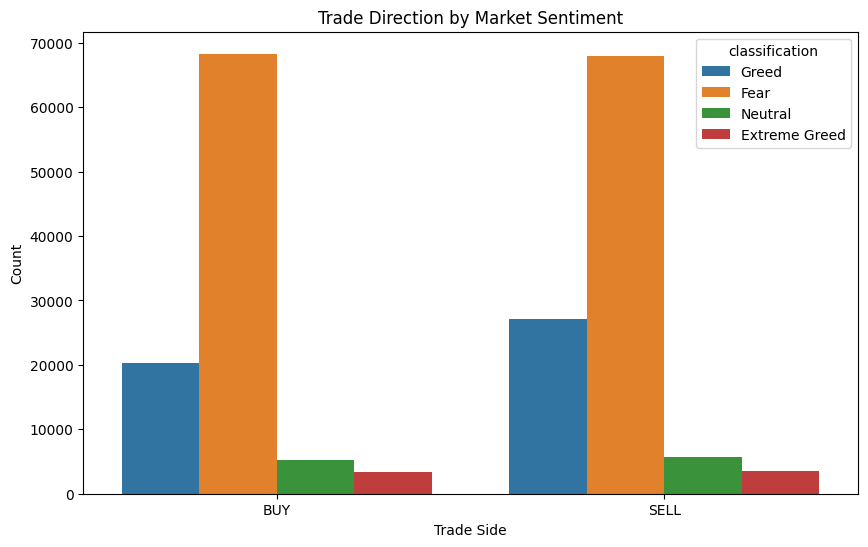

In [101]:
plt.figure(figsize=(10,6))
sns.countplot(x='Side', hue='classification', data=merged_data_cleaned)
plt.title('Trade Direction by Market Sentiment')
plt.xlabel('Trade Side')
plt.ylabel('Count')
plt.show()


5. Coin-Level Insights

Identify which coins are most traded and most profitable under different sentiments.

In [112]:
# Most traded coins
coin_volume = merged_data_cleaned.groupby(['Coin','classification'])['Size USD'].sum().reset_index()
print(coin_volume.sort_values('Size USD', ascending=False).head(10))

# Most profitable coins
coin_profit = merged_data_cleaned.groupby(['Coin','classification'])['Closed PnL'].sum().reset_index()
print(coin_profit.sort_values('Closed PnL', ascending=False).head(10))


     Coin classification      Size USD
162   BTC           Fear  3.299858e+08
229  HYPE           Fear  9.833374e+07
347   SOL           Fear  6.227170e+07
194   ETH           Fear  5.929682e+07
163   BTC          Greed  3.885781e+07
7    @107          Greed  2.993917e+07
6    @107           Fear  1.987861e+07
196   ETH        Neutral  1.653589e+07
195   ETH          Greed  1.595409e+07
193   ETH  Extreme Greed  1.511749e+07
        Coin classification    Closed PnL
7       @107          Greed  2.790036e+06
229     HYPE           Fear  1.745459e+06
194      ETH           Fear  1.158433e+06
347      SOL           Fear  9.170729e+05
272  MELANIA           Fear  5.580370e+05
162      BTC           Fear  5.128337e+05
6       @107           Fear  2.073463e+05
419      ZRO        Neutral  1.420540e+05
177     DOGE           Fear  1.265218e+05
163      BTC          Greed  1.090335e+05


6. Time-Series Trends

Plot average Closed PnL over time to see trends.

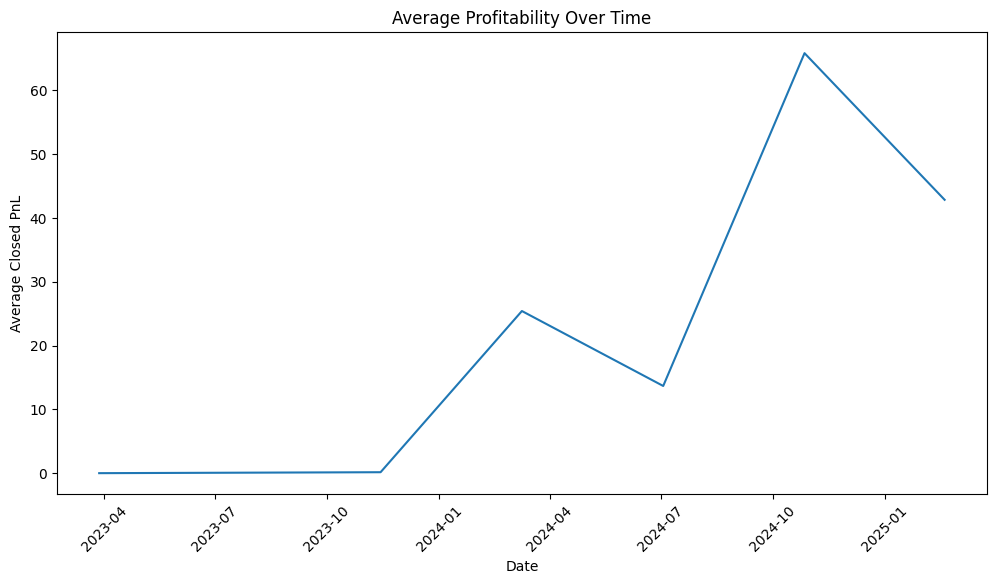

In [103]:
time_series_pnl = merged_data_cleaned.groupby('date')['Closed PnL'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(time_series_pnl['date'], time_series_pnl['Closed PnL'])
plt.title('Average Profitability Over Time')
plt.xlabel('Date')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=45)
plt.show()


7. Optional: Sentiment Value Correlation

If the sentiment dataset has a numeric value (0–100), you can check correlation with profitability.

In [113]:
pnl_sentiment_corr = merged_data_cleaned.groupby('classification').agg({'value':'mean','Closed PnL':'mean'}).reset_index()
print(pnl_sentiment_corr)

  classification      value  Closed PnL
0  Extreme Greed  84.000000   25.422374
1           Fear  44.000000   42.861211
2          Greed  73.888872   64.401067
3        Neutral  50.000000   13.671256
